## Reducing Timbre values using PCA
In notebook we explore an attempt to reduce the dimensionality of segment_timbre data within the mss_df using PCA.

Implementing PCA in Python Step by Step: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html.

### Problem: 
Timbre data is provided as a N x 12 matrix for each song (where N is the number of segments in a song.)  Therefore, it is difficult to use Timbre data as-is to create individual variables to add to a data frame with a row for each song.  

### Why PCA:
PCA is a method which can reduce the number of variables in a data set by taking advantage of correlation between variables.  Given Timbre is measured over time, we assume there must be some correlation between each time period.  This anlayis will show how to take advantage of that.

### Outcome:
This anlayis will show that the Timbre matrix can be reduced significantly using PCA.



In [38]:
import os
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py 
import os
import itertools
import re
import functools
import operator 
from sklearn.preprocessing import scale
save_load_path = '/Users/mikebrennan/Dropbox/Bentley/MA755'
%matplotlib inline

## Helper Functions
The following are helper functions for retrieving data provided by Professor Oury.

In [39]:
def get_filenames(path):
    return([get_filenames(path+"/"+entry.name)
            if entry.is_dir() 
            else path+"/"+entry.name 
            for entry 
            in os.scandir(path)
           ])
def unlist(alist):
    return(list(itertools.chain.from_iterable(alist)
               )
          )

def var_list(base,numof):
    return([base+str(ndx) for ndx in range(numof)]
          )

def h1d_array(in_array,n): 
    # n1d is the number of elements in `in_array`
    n1d = functools.reduce(operator.mul,
                           list(in_array.shape))
    # return a 1 row 2D array with `n` columns
    b = np.ndarray(shape=(1,n1d),
                   buffer=in_array,
                   dtype=in_array.dtype
                  )[0:1,0:n]
    return(b)
def check_HDF5_Group(Group):
    for key in list(Group.keys()):
        print('key:', key)
    for value in list(Group.values()):
        print('value:', value)

def check_HDF5_Dataset(Dataset):
    print('shape:',Dataset.shape)
    print('dtype:',Dataset.dtype)
    print('type(bc.value):',type(Dataset.value))
    print('value:',Dataset.value)
    
def make_1row_df(filename='', metadata_vars=[], analysis_vars=[], brainz_vars=[], remove=False):
    # open `filename` as a HDF5 file
    store = pd.HDFStore(filename,"r")
 
    if remove==True:
        # `metadata_vars` and `analysis_vars` contain the variables to remove
        metadata_vars = list({item for item 
                                  in list(store.root.metadata.songs.read().dtype.names) 
                                  if item not in metadata_vars})
        analysis_vars = list({item for item 
                                  in list(store.root.analysis.songs.read().dtype.names) 
                                  if item not in analysis_vars})
        brainz_vars = list({item for item 
                                  in list(store.root.musicbrainz.songs.read().dtype.names) 
                                  if item not in brainz_vars})
    # else: `metadata_vars` and `analysis_vars` contain the variables to keep
    
    # retrieve the first `n` values as a horizontal array of 1 dimension
    segments_timbre = np.matrix(store.root.analysis.segments_timbre.read())[0:200]
    segments_timbre  = segments_timbre.T.reshape(-1)
    
    segments_pitches = np.matrix(store.root.analysis.segments_timbre.read())[0:1]
    segments_pitches  = segments_timbre.T.reshape(-1)
    #bars_confidence  = h1d_array(store.root.analysis.bars_confidence.read(),10)
    artist_terms     = h1d_array(store.root.metadata.artist_terms.read(),3)
    
    # store these values as variables in single dataframes
    at_df = pd.DataFrame(artist_terms    ,columns=var_list('at_',artist_terms    .shape[1]))
    #bc_df = pd.DataFrame(bars_confidence ,columns=var_list('bc_',bars_confidence .shape[1]))
    #sp_df = pd.DataFrame(segments_pitches,columns=var_list('sp_',segments_pitches.shape[1]))
    st_df = pd.DataFrame(segments_timbre ,columns=var_list('st_',segments_timbre .shape[1]))
    #seg_df = pd.DataFrame(segments_timbre ,columns=var_list('seg_',segments_start .shape[1]))
    # merge these single dataframes into one single row dataframe
    ret = pd.concat([
            # retrieve a single row dataframe from `/metadata/songs`
            pd.DataFrame(store.root.metadata.songs.read(), 
                         columns=metadata_vars),
            # retrieve a single row dataframe from `/analysis/songs`
            pd.DataFrame(store.root.analysis.songs.read(), 
                         columns=analysis_vars),
            pd.DataFrame(store.root.musicbrainz.songs.read(), 
                         columns=brainz_vars),
            at_df, 
            #bc_df, 
            #sp_df,
           # seg_df,
            st_df],
            axis=1) # `axes=1` means stack the dataframes horizontally 
    # close the HDF5 file
    store.close()
 
    # return the merged dataframe
    return(ret)
    
    
path = "/Users/mikebrennan/desktop/MillionSongSubset/data"
x = unlist(unlist(unlist(get_filenames(path))))
p = re.compile("\.h5$")
y = [filename for filename in x if p.search(filename)]



## Extract The Timbre Data
The code below uses Professor Oury's helper functions to extract the first 200 segments of Timbre for every song in the data set.  It creates a list of data frames which will then be concatenated together into one.

In [40]:
master_data=[]
for i in range(10000):
    a=make_1row_df(filename=y[i],
                                remove=False
                               )
    a['song_id']=i
    master_data.append(a)
    if (i%500==0):
        print(i)

#timbre_master = pd.read_pickle(save_load_path+'/timbre_master.pkl')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


Master_data is a list of 10,000 single row data frame.  Each of which contains a song_id plus 2400 Timbre values.  (12 measure of timbre * 200 segments).

However, some songs are less than 200 segments long.  We want to be sure every record has the same number of columns.  So we drop everything which has less than 200 measurements of Timbre.

In [41]:
print(len(master_data)),
print(master_data[50].shape)

10000
(1, 2404)


In [42]:
drop_songs=[]
for i in range(10000):
    if master_data[i].shape[1]!=2404:
        drop_songs.append(i)
new = [i for i in master_data if int(i['song_id']) not in drop_songs]        

In [47]:
new[0]

,at_0,at_1,at_2,st_0,st_1,st_2,st_3,st_4,st_5,st_6,...,st_2391,st_2392,st_2393,st_2394,st_2395,st_2396,st_2397,st_2398,st_2399,song_id
0,b'hip hop',b'underground rap',b'g funk',0,19.991,20.597,20.908,22.173,32.381,29.165,...,-10.177,24.202,4.186,-2.245,-6.649,4.914,9.595,-13.901,-16.49,0


The "new" object is a list of all the songs with at least 200 segments of Timbre and 3 artist terms (9,552 songs). They are combined into one data frame titled "timbre_dataframe" below.

In [50]:
timbre_dataframe = pd.concat(new)
timbre_dataframe.shape

(9552, 2404)

## Perform PCA on Timbre
### Helper functions for the PCF Process
* <b>pcf(matrix)</b>: Ingests a Timbre matrix and returns the Eigen Values and Eigen Vectors for that matrix.
* <b>extract_eign(pair)</b>: Takes in an eigen value / eigen vector pair and returns only the eigen values
* <b>var_explained(eig,i)</b>: Injest an array of eigen values.  Returns how much variability in the data is explained by using the first i-th principle comonents within.  



In [52]:
def pcf(matrix):
    #scale the data
    A_s = scale(matrix, with_mean=True,with_std=True,axis=0)
    #covariance matrix
    A_c = np.corrcoef(A_s.T)
    #Get the eign values and eign vectors
    eig_val_cov, eig_vec_cov = np.linalg.eig(A_c)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i])
             for i in range(len(eig_val_cov))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort
    eig_pairs.reverse
    return(eig_pairs)

def var_explained(eig,i):
    value=[]
    for j in range(i):
        value.append(eig[j][0])
    cum_per=0
    per_var=0
    for e_val in (value):
        per_var = (e_val / len(eig))
        cum_per+=per_var
    return(cum_per)


## The Approach:
There are 12 measures of Timbre.  Our data frame contains the first 200 segments of Timbre measurements.  Meaning, columns 1-200 represent the first 200 segments of the 1st measure of Timbre.  Columns 201-400 represent the first 200 measures of the 2nd measure of timbre.  All the way up to columns 2200-2400 which represent the first 200 segments of the 12th measure of timbre.  

We first look at each measure of Timbre <b>Individually</b> to see how well each can be reduced using PCA.

In [58]:
##This code creates a list of 12 dataframes.  Each one represents the first 200 segements of a given measure of timbre.
##Example, timbre[0] represents the first 200 segements (for each song) of the first measure of timbre
timbre=[]
for i in range(0,12):
    timbre.append(timbre_dataframe.ix[:,3+(200*i):3+(200*(i+1))])

In [59]:
timbre[0].head()

,st_0,st_1,st_2,st_3,st_4,st_5,st_6,st_7,st_8,st_9,...,st_190,st_191,st_192,st_193,st_194,st_195,st_196,st_197,st_198,st_199
0,0.000,19.991,20.597,20.908,22.173,32.381,29.165,30.153,31.814,33.914,...,42.200,44.285,42.362,46.213,43.187,44.760,38.046,35.538,40.926,40.870
0,0.000,35.141,42.317,37.802,39.138,37.612,42.706,38.668,36.981,37.551,...,47.585,45.957,44.600,40.023,43.610,42.648,46.149,44.143,41.527,33.402
0,0.000,23.090,48.838,49.084,48.292,48.906,49.099,49.792,47.931,48.581,...,47.082,44.951,43.713,45.010,43.092,40.579,38.142,39.697,39.718,47.824
0,24.937,43.154,46.638,48.717,48.772,45.262,46.314,48.768,47.163,45.691,...,47.733,45.891,45.207,41.868,45.051,41.512,40.819,40.218,41.073,45.568
0,0.089,24.613,39.451,48.395,46.541,41.166,49.721,45.579,44.085,40.260,...,52.922,51.878,51.141,52.426,52.063,52.728,51.468,50.877,52.665,51.806


### Execute PCA
Now we run PCA on each of the 12 individual measure of Timbre to see how well we can reduce each one.

In [60]:
E=[]
for i in range(0,12):
    E.append(pcf(timbre[i]))

### Results
The following plots show just how well PCA worked against each of the 12 measures of Timbre.  The Y-axis shows % of variance explained and the X-axis shows the # of principle components used.  For example. plot 1 (Timbre measure 1) shows that very few components are required to explain nearly 80% of the variance.  However, the plot in the lower left (timbre component 10) is much more linear.  Meaning that it was very difficult to reduce this Timbre measure using PCA.

### Key Takeaway
Timbre measures 1, 2, and 3 responded the <b>best</b> to PCA reduction.

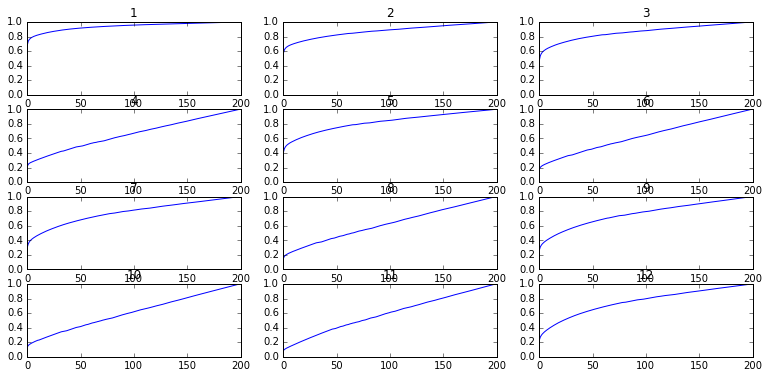

In [61]:
fig = plt.figure(1, figsize=(13,6))
for i in np.arange(12):
    plt.subplot(4,3,i+1)
    plt.plot([var_explained(E[i],x) for x in list(range(1,200))])
    plt.ylim(ymax = 1, ymin = 0)
    plt.title(i+1)

Given that Timbre measures 1, 2, and 3 respond Best to PCA, those are the three that will used in the final data frame.  

In [68]:
#This creates a dataframe containing the first 200 segments of timbre for the first 3 measures of timbre (600 columns)
timbre_1_2_3=(timbre_dataframe.ix[:,3:603])
timbre_1_2_3.head()

,st_0,st_1,st_2,st_3,st_4,st_5,st_6,st_7,st_8,st_9,...,st_590,st_591,st_592,st_593,st_594,st_595,st_596,st_597,st_598,st_599
0,0.000,19.991,20.597,20.908,22.173,32.381,29.165,30.153,31.814,33.914,...,-14.330,-57.872,-12.121,-4.520,-29.731,-10.517,-26.858,-101.884,1.680,-30.638
0,0.000,35.141,42.317,37.802,39.138,37.612,42.706,38.668,36.981,37.551,...,57.366,67.440,22.236,-13.244,-6.662,12.038,3.389,15.815,-14.003,35.490
0,0.000,23.090,48.838,49.084,48.292,48.906,49.099,49.792,47.931,48.581,...,62.475,62.100,111.824,18.335,48.311,-37.474,-43.475,-40.714,-31.258,67.000
0,24.937,43.154,46.638,48.717,48.772,45.262,46.314,48.768,47.163,45.691,...,123.056,117.616,88.340,106.494,37.511,104.067,47.817,91.986,111.016,39.777
0,0.089,24.613,39.451,48.395,46.541,41.166,49.721,45.579,44.085,40.260,...,37.163,69.618,59.490,44.713,76.318,43.885,67.802,59.189,49.721,78.497


In [69]:
#This code runs PCA against the dataframe created above.
E2=pcf(timbre_1_2_3)

The plot below shows how much variance explained for the first 200 segments of the 1st 3 measures of timbre we are able to get.  The X-axis shows the # of principle components.  We can see that with just 5 components we can explain 60% of the variance.  Thus, we are able to reduce 600 variables down to just 5 and still retain 60% explainability.

For the purposes of this assignment we will retain 15 components.

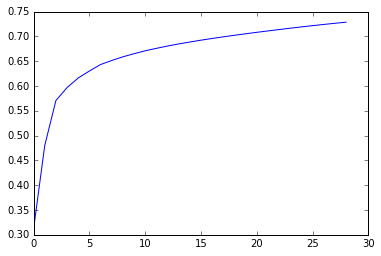

In [71]:
plt.plot([var_explained(E2,x) for x in list(range(1,30))])

The code block below shows we are able to retain 68.9% of the variance of the original 600 columns using only 15 Principle Components.  A huge reduction in dimensions.

In [73]:
var_explained(E2,15)

0.68865208030786285

The code below converts the weighted Eign Vectors stored in object E2 to actual Principle Components which can be added to our data frame.

In [93]:
component_list=[]
for i in range(len(timbre_1_2_3)):
    if(i % 500 == 0):
        print(i)
    Comp=[]
    source=timbre_1_2_3.iloc[i]
    for j in range(0,15):
        Comp.append(np.dot(source,E2[j][1]))
    component_list.append(Comp)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


## Final Result
Finally, these principle Components are merged into a single data frame.  This data frame was saved to a PKL file and eventually merged with other data sources we created.

In [94]:
tim_df=pd.DataFrame(component_list, columns=var_list('tim_comp_',15))

In [98]:
print(tim_df.shape)
tim_df.head()


(9552, 15)


,tim_comp_0,tim_comp_1,tim_comp_2,tim_comp_3,tim_comp_4,tim_comp_5,tim_comp_6,tim_comp_7,tim_comp_8,tim_comp_9,tim_comp_10,tim_comp_11,tim_comp_12,tim_comp_13,tim_comp_14
0,-567.682577,147.664203,-339.192207,-554.155393,-43.886136,-503.389146,-101.305289,-205.727265,60.576452,-33.136826,7.785124,63.447632,-10.015682,-14.503595,33.596925
1,-426.597316,-403.199195,-337.360209,-41.048973,-20.271638,-34.718046,-38.285278,93.569841,87.339023,-47.498931,21.051709,-94.022645,80.848612,82.302616,-41.181983
2,-64.802953,-1146.409999,-600.498833,215.668447,36.408786,183.837237,13.173252,87.954370,22.416583,39.733235,-2.457589,-35.811513,63.243426,70.074740,-17.469580
3,-922.796743,-651.817408,324.914535,49.357092,-36.502033,50.429332,36.231150,-42.645043,2.982978,166.385512,-7.049662,62.155778,39.160533,69.148130,-58.329949
4,-744.210501,-333.304990,-65.009973,-347.351662,-322.512785,91.695531,127.889116,42.358802,10.011409,-88.682259,-78.130060,-55.528248,45.142637,-106.970837,23.810118
